In [3]:
import numpy as np
from helpers import load_data
import scipy.sparse as sp

def read_files(files, path_root = '../submission/'):
    matrix_list = []
    for i,file_ in enumerate(files):
        matrix = load_data(path_root+file_)
        matrix_list.append(matrix)
    return matrix_list

files_submission = [ \
        'submission_0.06255_norm_unrounded_0.98431kaggle.csv', \
        'submission_surprise_unrounded_0.99256.csv']
files_train = [ \
        'train_surprise_unrounded_0.99256.csv']
files_full = []

file_train_true = '../data/data_train.csv'
#file_test_true = '../data/sampleSubmission.csv' 

errors_submission = [0.98431, 0.99256]

train_est = read_files(files_train)
submission_est = read_files(files_submission)
train_true = load_data(file_train_true)


number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


item min=3.0,max=522.0,min=117.6952
user min=8.0,max=4590.0,min=1176.952
item min, max, mean: 8 4590 1176.63663664
user min, max, mean: 0 2 1.00084867337


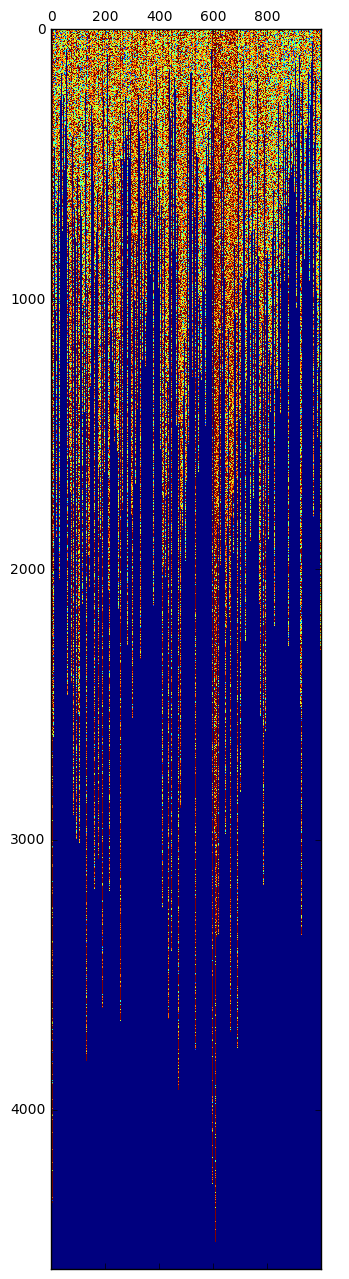

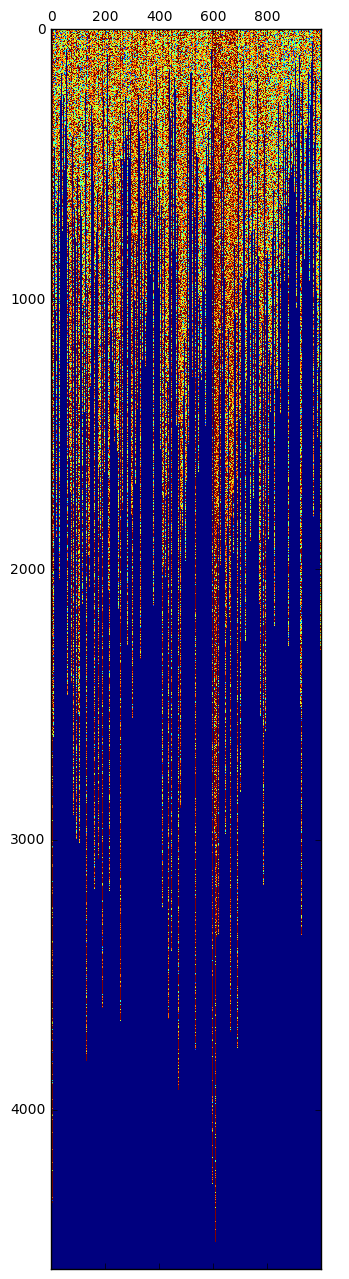

In [44]:
import matplotlib.pyplot as plt
% matplotlib inline

def statistics(sparse_matrix):
    rows, cols, ratings = sp.find(sparse_matrix)
    user_ratings = np.zeros(1000)
    item_ratings = np.zeros(10000)
    for i in range(10000):
        item_ratings[i] = np.count_nonzero(rows==i)
    for i in range(1000):
        user_ratings[i] = np.count_nonzero(cols==i)
    print('item min={},max={},min={}'.format(np.min(item_ratings),np.max(item_ratings),np.mean(item_ratings)))
    print('user min={},max={},min={}'.format(np.min(user_ratings),np.max(user_ratings),np.mean(user_ratings)))
    return item_ratings, user_ratings

def create_matrix_plot(sparse_matrix, axis=0, fname=''):
    # TODO: doesn't work for axis=1 because of how axes are organized!
    ''' Create a dense matrix plot, squeezing all entries along specified axis.

    input:
        sparse_matrix    - sparse matrix to visualize
        axis             - axis along which all nnz-elements will be squeezed.
    '''
    rows,cols,ratings = sp.find(train_true) 
    ratings_dense = np.zeros(train_true.shape)
    i_dense = 0
    i_total = []
    last_index = 0
    for i, rating in enumerate(ratings):
        if axis==0:
            index = cols[i]
        elif axis==1:
            index = rows[i]

        if index > last_index:
            i_total.append(i_dense)
            i_dense = 0
        
        if axis==0:
            ratings_dense[i_dense,index] = rating
        elif axis==1:
            ratings_dense[index, i_dense] = rating
        last_index = index
        i_dense += 1
    i_max=np.max(i_total)
    if axis==0:
        plt.matshow(ratings_dense[:i_max,:])
        return i_total, ratings_dense[:i_max,:]
    elif axis==1:
        plt.matshow(ratings_dense[:,:i_max])
        return i_total, ratings_dense[:,:i_max]

its, uss = statistics(train_true)
dense_matrices=[]
dense_matrices.append(ratings_dense)
i_total, ratings_dense = create_matrix_plot(train_true, axis=0)
#j_total, _ = create_matrix_plot(train_true, axis=1)
print('item min, max, mean:',np.min(i_total), np.max(i_total), np.mean(i_total))
print('user min, max, mean:',np.min(j_total), np.max(j_total), np.mean(j_total))
for matrix_est in train_est:
    __, ratings_dense = create_matrix_plot(matrix_est, axis=0)
    dense_matrices.append(ratings_dense)

0.0


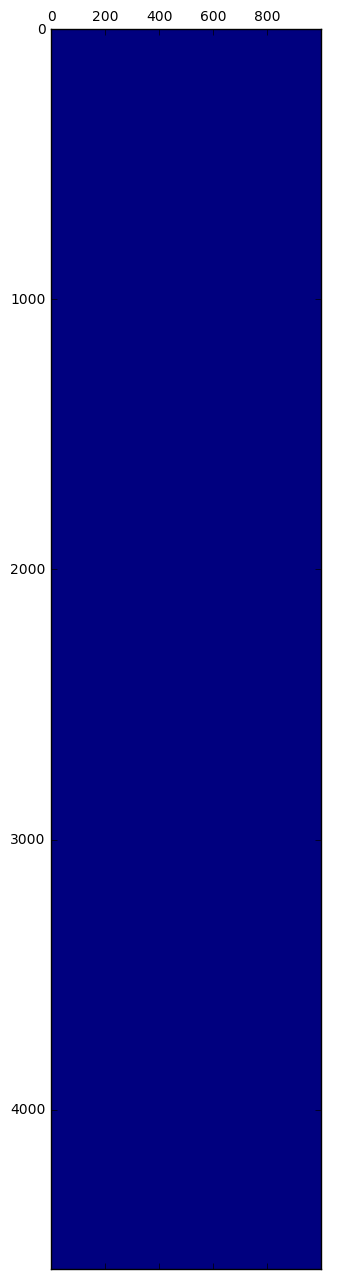

In [49]:
diff_matrix = dense_matrices[1]-dense_matrices[0]
print(np.max(np.mean(diff_matrix,axis=0)))
plt.matshow(5*diff_matrix)